In [1]:
# 从 到核函数K1 之间的映射
# 这个notebook使用DeepONet来学习从参数到核函数的映射，替代传统的数值求解方法
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
# from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
from scipy import linalg
from scipy.interpolate import interp1d
import datetime

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
D:\Anaconda\envs\DeepONetEnv2\lib\site-packages\torch\__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


In [2]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)

In [3]:
# ======================================================
# Utility Functions (使用预计算的lambda向量)
# ======================================================
def compute_G(x_grid, h_val, N_val, lam_vec_at_t, c_val, eps_val):
    """计算对角线元素G，使用预计算的lambda向量"""
    f = lam_vec_at_t + c_val
    cum = np.zeros(N_val)
    for i in range(1, N_val):
        cum[i] = cum[i-1] + 0.5 * h_val * (f[i-1] + f[i])
    G = -(1.0 / (2.0 * eps_val)) * cum
    return G

def apply_diagonal_bc(k_mat, G_vec, N_val):
    """应用对角线边界条件"""
    for i in range(N_val):
        k_mat[i, i] = G_vec[i]
        if i + 1 < N_val:
            k_mat[i, i+1:N_val] = 0.0
    return k_mat

def solve_tridiag(a, b, c_upper, r):
    """求解三对角线性系统"""
    n = len(b)
    ac = a.copy()
    bc = b.copy()
    cc = c_upper.copy()
    rc = r.copy()
    
    for i in range(1, n):
        m = ac[i] / bc[i-1]
        bc[i] = bc[i] - m * cc[i-1]
        rc[i] = rc[i] - m * rc[i-1]
    
    x = np.zeros(n)
    x[n-1] = rc[n-1] / bc[n-1]
    for i in range(n-2, -1, -1):
        x[i] = (rc[i] - cc[i] * x[i+1]) / bc[i]
    
    return x

# ======================================================
# IMEX step: implicit in y, explicit in x and reaction
# ======================================================
def imex_step(k, lam_now, dt, x, y, h, N, eps, c, q, USE_LAMBDA_OF_Y_IN_PDE):
    """
    IMEX步进函数，使用预计算的lambda向量
    n_step: 当前时间步索引
    """
    # 获取n+1时刻的lambda值
    #lam_x_np1 = lam_x_all[:, n_step + 1]
    lam_x_np1 = lam_now
    G_np1 = compute_G(x, h, N, lam_x_np1, c, eps)
    
    # 获取n时刻的lambda值
    #lam_x_n = lam_x_all[:, n_step]
    #lam_y_n = lam_y_all[:, n_step]
    lam_x_n = lam_now
    lam_y_n = lam_now
    
    k_next = k.copy()
    
    for i in range(1, N-1):
        m = i + 1
        if m == 1:
            k_next[i, i] = G_np1[i]
            continue
        
        a = np.zeros(m)
        b = np.zeros(m)
        c_upper = np.zeros(m)
        
        b[0] = 1.0 + dt * eps * (2.0 * (1.0 + h * q) / h**2)
        if m >= 2:
            c_upper[0] = dt * eps * (-2.0 / h**2)
        
        for j in range(1, m-1):
            a[j] = dt * eps * (-1.0 / h**2)
            b[j] = 1.0 + dt * eps * (2.0 / h**2)
            c_upper[j] = dt * eps * (-1.0 / h**2)
        
        if m >= 2:
            a[m-1] = dt * eps * (-1.0 / h**2)
            b[m-1] = 1.0 + dt * eps * (2.0 / h**2)
        
        r = np.zeros(m)
        for j in range(m):
            r[j] = k[i, j]
            
            if i - 1 == j:
                left = G_np1[i-1]
            else:
                left = k[i-1, j]
            right = k[i+1, j]
            kxx_n = (right - 2.0 * k[i, j] + left) / h**2
            r[j] = r[j] + dt * eps * kxx_n
            
            if USE_LAMBDA_OF_Y_IN_PDE:
                lam_here = lam_y_n[j]
            else:
                lam_here = lam_x_n[i]
            
            r[j] = r[j] + dt * (-(lam_here + c) * k[i, j])
        
        r[m-1] = r[m-1] + dt * eps * (1.0 / h**2) * G_np1[i]
        
        col_sol = solve_tridiag(a, b, c_upper, r)
        k_next[i, :m] = col_sol
        k_next[i, i] = G_np1[i]
    
    k_next[0, 0] = G_np1[0]
    return k_next
    
#求控制U
def solveControl(k, u_now,lam, dy,Ny,Nx):
    U=0
    temp1=0
    for j in range(Ny):
        temp1+= k[Nx-5,j]*u_now[j]*dy  #修改 k[Nx-3,j]  matlab中的k[Nx-3,j]是python  k[Nx-4,j]
    U=temp1
    return U

#开环控制 U=0
def solveControl_Openloop(k, u_now,lam, dy,Ny,Nx):
    U=0
    return U

# ======================================================
# 统一求解核k和状态u的函数
# ======================================================
def solve_state_implicit_euler(x, y, tt, imex_step_func, eps, c, q, 
                                lam_x_all, lam_y_all, u0_func, 
                                initial_k_func, USE_LAMBDA_OF_Y_IN_PDE,solveControlFunc):
    """使用隐式欧拉法求解核k和状态方程u，使用预计算的lambda向量"""
    
    Nx = len(x)
    Ny = len(y)
    Nt = len(tt)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    h = dx
    dt = tt[1] - tt[0]
    
    # ======================================================
    # 初始化核k和状态u
    # ======================================================
    #print('开始同步求解核函数k和状态u...')
    
    # 初始化核k
    k0 = np.zeros((Nx, Ny))
    for i in range(Nx):
        for j in range(i):
            k0[i, j] = initial_k_func(x[i], y[j])
    
    # 使用t=0时刻的lambda值
    lam_x_0 = lam_x_all[:, 0]
    G0 = compute_G(x, h, Nx, lam_x_0, c, eps)
    k0 = apply_diagonal_bc(k0, G0, Nx)
    
    # 分配存储所有时间步的3D数组
    K_all = np.zeros((Nt, Nx, Ny))
    K_all[0, :, :] = k0
    
    # 初始化状态u
    u_record = np.zeros((Nx, Nt))
    u_record[:, 0] = u0_func(x)
    u = u_record[:, 0].copy()
    U = np.zeros(Nt)
    
    # 扩散系数比
    r = eps * dt / dx**2
    
    # ======================================================
    # 统一时间循环：同时求解k和u
    # ======================================================
    k = k0.copy()
    
    for n in range(Nt - 1):
        # ----- 步骤1: 更新核函数k -----
        #k = imex_step_func(k, n, dt, x, y, h, Nx, eps, c, q, lam_x_all, lam_y_all, USE_LAMBDA_OF_Y_IN_PDE)
        lam_now =  lam_x_all[:, n] 
        k = imex_step_func(k, lam_now, dt, x, y, h, N, eps, c, q, USE_LAMBDA_OF_Y_IN_PDE)  #切记不要硬写imex_ste
        K_all[n+1, :, :] = k
        
        # ----- 步骤2: 更新状态u -----
        # 构造右端项b
        b = u[1:Nx-1].copy()
        
        # Robin左边界: u_x(0,t) = q*u(0,t)
        b[0] = b[0] + r * (u[1] / (1 + q * dx))
        
        # 右边界: u(1,t)=U(t) 
        b[-1] = b[-1] + r * U[n+1]
        
        # 更新lambda项，使用n时刻的lambda值
        lam_vec_inner = lam_x_all[1:Nx-1, n]
        A_eff = (1 + 2*r - lam_vec_inner * dt) * np.eye(Nx-2)
        A_eff -= r * np.diag(np.ones(Nx-3), 1)
        A_eff -= r * np.diag(np.ones(Nx-3), -1)
        
        # 隐式欧拉求解
        u_inner = np.linalg.solve(A_eff, b)
        
        # 拼接边界点
        u_left = u_inner[0] / (1 + q * dx)
        u_new = np.concatenate([[u_left], u_inner, [U[n+1]]])
        
        # 更新
        u = u_new.copy()
        u_record[:, n+1] = u

        u_now = u
        #U_now = solveControl(k, u_now, dy,Ny,Nx):
        # 根据当前k和u计算下一步控制输入U (闭环控制)
        if n + 1 < Nt - 1:
            #temp1 = 0.0
            #for j in range(Ny):
                #temp1 += K_all[n+1, Nx-3, j] * u_record[j, n+1] * dy
            #print(lam_vec_inner.shape)
            U_now = solveControlFunc(k, u_now, lam_x_all[:, n+1],dy,Ny,Nx) 
            U[n+2] = U_now # temp1
        
        # 开环控制(取消注释下面这行,注释上面的积分计算)
        # U[n+2] = 0
        
        # ----- 步骤3: 输出进度信息 -----
        #if n % max(1, (Nt - 1) // 10) == 0:
            #tri_norm2 = 0.0
            #maxabs = 0.0
            #for i in range(Nx):
                #row = k[i, :i+1]
                #tri_norm2 += np.sum(row**2)
                #maxabs = max(maxabs, np.max(np.abs(row)))
            #t_current = tt[n+1]
            #print(f'step {n:5d}/{Nt-1}, t={t_current:.4f}, ||k||≈{np.sqrt(tri_norm2):.3e}, max|k|≈{maxabs:.3e}')
    print('核函数k和状态u求解完成！')
    return u_record, U, K_all

def buildc(Nx,c):
    c_matrix = c * np.ones((Nx, Nx))
    # tau_matrix = np.triu(tau_matrix)
    c_matrix = c_matrix.reshape(1, -1)
    return c_matrix
def zeroToNan(x):
    for j in range(len(x)):
        for i in range(len(x)):
            if j > i:
                x[i][j] = float('nan')
    return x

def zeroToNan2(x):
    for j in range(len(x)):
        for i in range(len(x)):
            if j < i:
                x[i][j] = float('nan')
    return x
    
# PDE L2 Error
def getPDEl2(u, uhat):
    pdeError = np.zeros(nt-1)
    for i in range(1, nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error*0.01)
        pdeError[i-1] = error
    return pdeError
    
# 向量
#def lam_vec(grid_1d, time_now, lam_func):
    #return lam_func(grid_1d, time_now)

# 句柄函数-Lambda function
#def lam(x_or_y, time_now):
    #return 1.0 + np.sin(np.pi * x_or_y) * np.sin(np.pi * time_now)

# Initial condition
def initial_k(x, y):
    return 0.0
# 句柄函数-Lambda 复杂形式的函数
def solveBetaFunctionVar(x_or_y, time_now,sigma_value):
    return 5.0 + np.cos(sigma_value * np.arccos(x_or_y)) + np.sin(sigma_value * time_now) 

In [4]:
# ======================================================
# Parameters
# ======================================================
eps = 1.0          # eps=1 本身就稳定; eps=0.1 开环不稳定，闭环也不稳定
c = 1.0
q = 0.5
T = 20  #修改T 2.5  10
N = 20             # spatial points
Nx=N
Ny=N
alpha_x = 0.25     # CFL-like limit for explicit part
USE_LAMBDA_OF_Y_IN_PDE = True

# ======================================================
# Grid and time step
# ======================================================
h = 1.0 / N
dx = h
dy=dx
x = np.arange(N) * h
y = np.arange(N) * h
dt = alpha_x * h * h / eps
M = max(1, int(np.ceil(T / dt)))
dt = T / M
tt = np.arange(M + 1) * dt

print(f'h={h:.3e}, dt={dt:.3e}, M={M}, eps*dt/h^2={eps*dt/h**2:.3e}')

# ======================================================
# 预计算Lambda向量 (Nx x Nt) 和 (Ny x Nt)
# ======================================================
sigma_value = 3.25
lam_x_all = np.zeros((N, M + 1))  # lambda(x, t) for all x and t
lam_y_all = np.zeros((N, M + 1))  # lambda(y, t) for all y and t

for n in range(M + 1):
    t = tt[n]
    lam_x_all[:, n] =  5.0 + np.cos(sigma_value * np.arccos(x)) + np.sin(sigma_value * t) 
    lam_y_all[:, n] =  5.0 + np.cos(sigma_value * np.arccos(y)) + np.sin(sigma_value * t) 

print('Lambda向量预计算完成')

# Initial condition
initial_k = lambda x_val, y_val: 0.0

u0_func = lambda x_val: 10.25 * x_val * (1 - x_val)

h=5.000e-02, dt=6.250e-04, M=32000, eps*dt/h^2=2.500e-01
Lambda向量预计算完成


In [5]:
# 初始化核k
k0 = np.zeros((Nx, Ny))
for i in range(Nx):
    for j in range(i):
        k0[i, j] = initial_k(x[i], y[j])

# 使用t=0时刻的lambda值
lam_x_0 = lam_x_all[:, 0]
G0 = compute_G(x, h, Nx, lam_x_0, c, eps)
k0 = apply_diagonal_bc(k0, G0, Nx)


In [6]:
# Dataset generation 
xArr = []
yArr = []
lam_x_all = np.zeros((N, M + 1))
# Build Dataset
for ii in range(100): # 取10个采样的sigma值  #以后改成100个 服从U(2,4) 
    if ii % 10 == 0: 
        print('ii',ii)
    sigma_value = np.random.uniform(3, 4)
    #print(sigma_value)
    time_now = 0 
    #print(M) # 100000
    k = k0.copy()
    for n in range(500):
        n_timeStep = n*round(M/500)
        t = tt[n_timeStep]
        lam = solveBetaFunctionVar(x, t, sigma_value)
        #t = tt[n*round(M/10)]
        #time_now = time_now + dt*(M/100)
        #print(time_now)
        #lam_x_n = lam_vec(x, t, lam_func)
        #lam_vec_sigma_y = solveBetaFunctionVar(y, time_now,sigma_value)#句柄函数
        
        #lam_x_all[:, n] = solveBetaFunctionVar(x, t, sigma_value)
        #lam_y_all[:, n] = solveBetaFunctionVar(y, t, sigma_value)
        #k = imex_step(k, time_now, dt, x, y, h, N, eps, c, q, lam_vec_sigma_y, USE_LAMBDA_OF_Y_IN_PDE)
        #k = imex_step(k, time_now, dt, x, y, h, N, eps, c, q, lam_vec_sigma_y, USE_LAMBDA_OF_Y_IN_PDE)
        #k = imex_step(k, n, dt, x, y, h, Nx, eps, c, q, lam_x_all, lam_y_all, USE_LAMBDA_OF_Y_IN_PDE)
        k = imex_step(k, lam, dt, x, y, h, N, eps, c, q, USE_LAMBDA_OF_Y_IN_PDE)
        lam_matrix = buildc(Nx,lam)
        #print(lam_matrix.size) # 10000
        #print(lam_matrix)
        tempin = np.concatenate([lam_matrix.reshape(1, -1)], axis=1)
        tempout = np.concatenate([k.reshape(1,-1)],axis=1)
        xArr.append(tempin)
        yArr.append(tempout)
x = np.array(xArr)
y = np.array(yArr)
x = x.reshape(x.shape[0],1*Nx*Nx)  #注意是 输入是1个变量
y = y.reshape(y.shape[0],1*Nx*Nx)  # 输出是1个变量     
np.savetxt("x_k-IMEX.dat", x)
np.savetxt("y_k-IMEX.dat", y)

ii 0
ii 10
ii 20
ii 30
ii 40
ii 50
ii 60
ii 70
ii 80
ii 90


In [7]:
# Parameters tranin
ndata1 =500 #注意ndata1=ndata2 表明c和lambda的重要性一样，； q_learning 数据是200*200
#ndata2 = 100
ndata=ndata1 #ndata1*ndata2
epochs =200
ntrain = ndata*0.9
ntest = ndata*0.1
batch_size = 10
gamma2 = 0.6 # 笔记：注意别跟你设定的变量名重复
learning_rate = 0.0002
step_size= 50 # 50
# modes=12
# width=32


inpArr = np.loadtxt("x_k-IMEX.dat", dtype=np.float32)
outArr = np.loadtxt("y_k-IMEX.dat", dtype=np.float32)
x = np.array(inpArr)
y = np.array(outArr) 


grids0 = []
grids0.append(np.linspace(0, 1, Nx, dtype=np.float32))
grids0.append(np.linspace(0, 1, Nx, dtype=np.float32))
grid0 = np.vstack([xx.ravel() for xx in np.meshgrid(*grids0)]).T
grid = torch.from_numpy(grid0).cuda()


# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [8]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp




class BranchNet1(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64,  #  改in_channels=2 原来是3  输出的深度为什么选择64？
                       kernel_size=3, stride=2) # 卷积核的尺寸是5，步长是2
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,
                       kernel_size=3, stride=2)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(2048, 512)# 128 epoch =150;2048 epoch=300
        self.fc2 = torch.nn.Linear(512, 256)
        
    def forward(self, x): 
        x = torch.reshape(x, (x.shape[0], 1, self.shape, self.shape)) #改2
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
    
    
# Define a sequential torch network for batch and trunk. 
dim_x = 2 
m1 = 1*Nx*Nx                                              # p2
branchk1 = BranchNet1(Nx) # 分支网络的输入通道数是Nx
modelk1 = dde.nn.DeepONetCartesianProd([m1, branchk1], [dim_x, 128,  256], "relu", "Glorot normal").cuda()
modelk11 = dde.nn.DeepONetCartesianProd([m1, branchk1], [dim_x, 128,  256], "relu", "Glorot normal").cuda()

print(count_params(modelk1))



optimizer = torch.optim.Adam([
	{'params': modelk1.parameters(), 'lr': learning_rate,} 
	]) #改gamma
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma2)

1288321


In [9]:
# loss = nn.MSELoss()
loss = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0)

train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    #modelk1.train()
    # modelk2.train()
    modelk1.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        # x1=x[:,nx*nx:4*nx*nx]
        # y1=y[:,0:nx*nx]
        # y2=y[:,nx*nx:2*nx*nx]
        # y3=y[:,2*nx*nx:3*nx*nx]
        optimizer.zero_grad()
        out = modelk1((x, grid)) # 改gamma 2
        # out2 = modelk2((x, grid))
        # out3 = modelk3((x, grid))
        lp = loss(out.view(batch_size, -1), y.view(batch_size, -1)) 
        # + loss(out2.view(batch_size, -1), y2.view(batch_size, -1)) \
        # + loss(out3.view(batch_size, -1), y3.view(batch_size, -1))
        lp.backward()
        
        optimizer.step() #报错
        train_loss += lp.item()
        
    scheduler.step()
    modelk1.eval()
    #modelk2.eval()
    #modelk3.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            # x1=x[:,nx*nx:4*nx*nx]
            # y1=y[:,0:nx*nx]
            # y2=y[:,nx*nx:2*nx*nx]
            # y3=y[:,2*nx*nx:3*nx*nx]
            out = modelk1((x, grid))  # 改gamma 2
            #out = modelk2((x, grid))
            # out3 = modelk3((x, grid))
            test_loss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()  
            # +loss(out2.view(batch_size, -1), y2.view(batch_size, -1)).item() \
            # +loss(out3.view(batch_size, -1), y3.view(batch_size, -1)).item() 
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    #print(ep, t2-t1, np.mean(train_lossArr[-50:]), np.mean(test_lossArr[-50:]))
    if ep%50 == 0:
        print(ep, t2-t1, np.mean(train_lossArr[-50:]), np.mean(test_lossArr[-50:]),datetime.datetime.now())
        # print()

0 21.209077800000003 0.006069033075828985 0.0020462006623856725 2026-02-24 22:28:07.924388
50 19.198482400000103 0.001608756092886518 0.0016127098798623775 2026-02-24 22:44:27.909968
100 19.262956199999735 0.0015313711652123149 0.0015610989335554768 2026-02-24 23:00:37.116434
150 19.52823999999964 0.0015222834290270434 0.0015461117129601186 2026-02-24 23:16:46.766233


Avg Epoch Time: 19.496896921000012
Final Testing Loss: 0.7698757995240157
Final Training Loss: 6.835283865497331


Text(0.5, 0, '$\\mathrm{epoch}$')

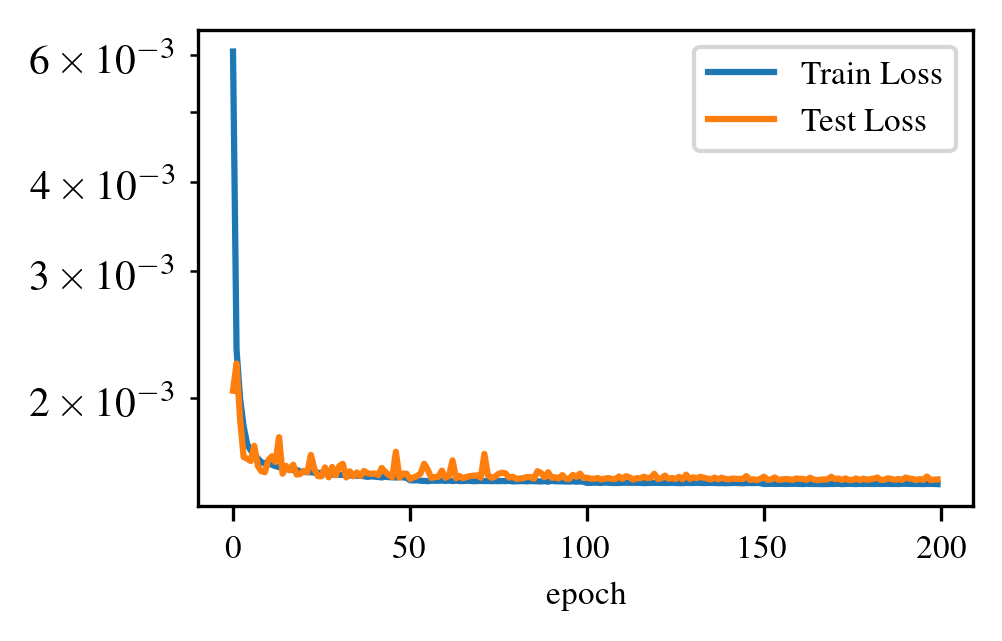

In [10]:
# Display Model Details
plt.figure(figsize=(1000 / 300, 618 / 300), dpi=300)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(train_lossArr, label="Train Loss",linewidth=1.5)
plt.plot(test_lossArr, label="Test Loss",linewidth=1.5)
plt.yscale("log")
plt.legend(fontsize="8")

testLoss = 0
trainLoss = 0
with torch.no_grad():
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        out = modelk1((x, grid))
        out = out.reshape((out.shape[0], out.shape[1]))
        trainLoss +=  loss(out.view(batch_size, -1), y.view(batch_size, -1)).item() 
        
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
        out = modelk1((x, grid))
        out = out.reshape((out.shape[0], out.shape[1]))
        testLoss +=   loss(out.view(batch_size, -1), y.view(batch_size, -1)).item() 
    
    
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
print("Final Testing Loss:", testLoss)
print("Final Training Loss:", trainLoss)
plt.tick_params(labelsize=8)
plt.xlabel(r"$\mathrm{epoch}$",fontsize = 8 )
# plt.savefig('img/Kloos.eps', dpi=300,bbox_inches='tight')


In [11]:
# kernel误差
#参数
x = np.arange(N) * h
y=x
X, Y = np.meshgrid(x, x)
Nx = N
Nt = M + 1
# ======================================================
# 预计算Lambda向量 (Nx x Nt) 和 (Ny x Nt)
# ======================================================
sigma_value = 3.3  # 验证的参数
lam_x_all = np.zeros((N, M + 1))  # lambda(x, t) for all x and t
lam_y_all = np.zeros((N, M + 1))  # lambda(y, t) for all y and t

for n in range(M + 1):
    t = tt[n]
    #lam_x_all[:, n] = 1.0 + np.sin(sigma_value * x) * np.sin(sigma_value * t)
    #lam_x_all[:, n] = 1.0 + np.exp(x) * np.cos(sigma_value * t)
    #lam_y_all[:, n] = 1.0 + np.sin(sigma_value * y) * np.sin(sigma_value * t)
    #lam_x_all[:, n] = 1.0 + np.exp(sigma_value * x) * np.cos(sigma_value * t)
    #lam_y_all[:, n] = 1.0 + np.exp(sigma_value * x) * np.cos(sigma_value * t)
    lam_x_all[:, n] =  5.0 + np.cos(sigma_value * np.arccos(x)) + np.sin(sigma_value * t) 
    lam_y_all[:, n] =  5.0 + np.cos(sigma_value * np.arccos(y)) + np.sin(sigma_value * t) 

# Initial condition
initial_k = lambda x_val, y_val: 0.0
# ======================================================
# 主程序---得到 K_all
# ======================================================
u0_func = lambda x_val: 10.25 * x_val * (1 - x_val)

#u_record, U, K_all = solve_state_implicit_euler(x, y, tt, imex_step, eps, c, q, lam_x_all, lam_y_all, u0_func, initial_k, USE_LAMBDA_OF_Y_IN_PDE)

#传统
u_record, U, K_all = solve_state_implicit_euler(
    x, y, tt, imex_step, eps, c, q, lam_x_all, lam_y_all, 
    u0_func, initial_k, USE_LAMBDA_OF_Y_IN_PDE,solveControl
)

#开环
#u_record_open, U_open, K_all_open = solve_state_implicit_euler(
    #x, y, tt, imex_step, eps, c, q, lam_x_all, lam_y_all, 
    #u0_func, initial_k, USE_LAMBDA_OF_Y_IN_PDE,solveControl_Openloop)

核函数k和状态u求解完成！


In [12]:
# 验证闭环系统
# 直接函数评估得到 kernel
def nopKernel(k, lam_now, dt, x, y, h, N, eps, c, q, USE_LAMBDA_OF_Y_IN_PDE):
    with torch.no_grad():
        # lam_x_np1 = lam_x_all[:, n_step + 1] 也有可能是n+1
        # 获取n时刻的lambda值
        #lam_x_n = lam_x_all[:, n_step]
        lam_matrix = buildc(Nx,lam_now)
        xdata = np.concatenate([lam_matrix.reshape(1,-1)],axis=1)
        xdata = np.array(xdata, dtype=np.float32)
        xdata = torch.from_numpy(xdata.reshape((1, 1*Nx*Nx))).cuda() # gamma改2
        xdata1=xdata[:,0*Nx*Nx:1*Nx*Nx] # [:,0*Nx*Nx:2*Nx*Nx] 前两个 0,1
        #print(xdata1)
        #print(x.shape[0]) 21
        l_1 = modelk1((xdata1, grid))
        l_1 = l_1.detach().cpu().numpy().reshape(1, Nx*Nx)
        l_1 = l_1.reshape(Nx,Nx)
        return l_1  #别忘了加它。要不然U_N就是nan

#用NO近似的核k  (nopKernel)
u_record_NO, U_NO, K_all_NO = solve_state_implicit_euler(
    x, y, tt, nopKernel, eps, c, q, lam_x_all, lam_y_all, 
    u0_func, initial_k, USE_LAMBDA_OF_Y_IN_PDE,solveControl
)

核函数k和状态u求解完成！


In [13]:
#print(u_record)
#print(u_record_NO)
verror = u_record-u_record_NO
print("verror",verror) 
Kerror = K_all-K_all_NO
print("Kerror",Kerror)
print("K_all[M,:,:]",K_all[M,:,:])

verror [[ 0.00000000e+00  0.00000000e+00  1.25455202e-14 ... -1.03812237e-02
  -1.03795772e-02 -1.03779179e-02]
 [ 0.00000000e+00  0.00000000e+00  1.28785871e-14 ... -1.06407543e-02
  -1.06390666e-02 -1.06373658e-02]
 [ 0.00000000e+00  0.00000000e+00  7.71605002e-14 ... -1.07514675e-02
  -1.07497503e-02 -1.07480198e-02]
 ...
 [ 0.00000000e+00  0.00000000e+00  2.28321642e-02 ...  3.48362962e-04
   3.48633426e-04  3.48912144e-04]
 [ 0.00000000e+00  0.00000000e+00  1.32797008e-01 ...  1.48483259e-03
   1.48558256e-03  1.48585437e-03]
 [ 0.00000000e+00  0.00000000e+00  7.72261909e-01 ...  2.60237210e-03
   2.60673936e-03  2.60509587e-03]]
Kerror [[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 0.00000000e+00  0.0

In [50]:
import matplotlib as mpl

#vmin = min(u.min(), uhat.min())
#vmax = max(u.max(), uhat.max())
#norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("viridis")   # 你也可以用 "turbo", "plasma", "coolwarm"

(20,)


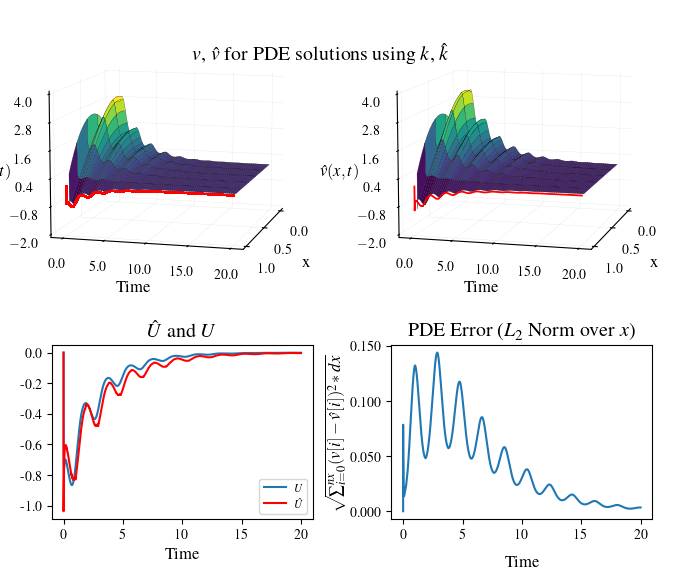

In [52]:
#画基于NO近似的控制Uhat、状态uhat

x = np.arange(N) * h
print(x.shape)
spatial = x
temporal=tt
u = u_record.T
uhat = u_record_NO.T
nt=Nt
nx=Nx

# 状态u
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (2, 2), height_add=1))
plt.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.suptitle(r"$v$, $\hat{v}$ for PDE solutions using $k$, $\hat{k}$")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
#ax[0].plot_surface(meshx, mesht, u, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        #alpha=1, color="white", shade=False, rasterized=True)
surf0 = ax[0].plot_surface(
    meshx, mesht, u,
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=400, cstride=4,
    antialiased=True, shade=True, rasterized=True
)

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    

    
# uhat 
test = np.ones(nt)
vals = (u.transpose())[-1] 
zticks = np.linspace(-2, 4, 6)

ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)



ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$v(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#ax[1].plot_surface(meshx, mesht, uhat, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        #alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
surf1 = ax[1].plot_surface(
    meshx, mesht, uhat,
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=400, cstride=4,
    antialiased=True, shade=True, rasterized=True
)

test = np.ones(nt)
vals = (uhat.transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$\hat{v}(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])

ax[1].set_zticks(zticks) #限制z轴的大小
ax[0].set_zticks(zticks)

#状态误差 getPDEl2(u, uhat)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
yticks = np.linspace(0, 1, 5)
subfig = subfigs[1]
ax = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.85, wspace=0.3, hspace=0.1)
ax[1].plot(temporal[1:], getPDEl2(u, uhat))
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[1].set_xlabel("Time", labelpad=10)
ax[1].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (v[i] - \hat{v}[i])^2*dx}$")
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax[1].title.set_text(r"PDE Error ($L_2$ Norm over $x$)")
#ax[1].set_yticks(yticks)


# 控制 U
#control = U #(u.transpose())[-1]
#print(U.shape)
#chat = U_NO #(uhat.transpose())[-1]

#ax[0].plot(temporal[1:], control[1:], label=r"$U$")   
#ax[0].plot(temporal[1:], chat[1:], label=r"$\hat{U}$", color="red")
ax[0].plot(temporal[1:], U[1:], label=r"$U$")   
ax[0].plot(temporal[1:], U_NO[1:], label=r"$\hat{U}$", color="red")

ax[0].legend()
ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[0].set_xlabel("Time")
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].title.set_text(r"$\hat{U}$ and $U$")

# 创建放大镜子图 (右上角)

#from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# 创建放大镜子图 (右上角)
#axins = ax[0].inset_axes([0.55, 0.45, 0.4, 0.4])  # [left, bottom, width, height] (相对坐标)  ([0.55, 0.45, 0.4, 0.4]) 
#axins.plot(temporal[1:], U[1:], label=r"$U$")
#axins.plot(temporal[1:], U_NO[1:], label=r"$\hat{U}$", color="red")

# 设置放大区域 (自己根据需要调整)
#x1, x2 = 19, 20      # 放大时间区间 18，20
#y1, y2 = -0.05, 0.05 # 放大 U 区域
#axins.set_xlim(x1, x2)
#axins.set_ylim(y1, y2)

# 去掉多余刻度
#axins.set_xticks([])
#axins.set_yticks([])

# 画出放大区域的连线
#ax[0].indicate_inset_zoom(axins, edgecolor="black")


#plt.savefig("img/U_u_uNO2-2.png", dpi=600)
plt.savefig("img/U_u_uNO2_2.pdf", bbox_inches="tight")

In [16]:
#===================
# l-- 最终时刻 M
#=====================
n=round(M)  #时刻
t = tt[n]
lam_x_all_1 = np.zeros(Nx)
lam_x_all_1 = solveBetaFunctionVar(x, t, sigma_value)
#lam_y_all[:, n] = solveBetaFunctionVar(y, t, sigma_value)
#k = imex_step(k, time_now, dt, x, y, h, N, eps, c, q, lam_vec_sigma_y, USE_LAMBDA_OF_Y_IN_PDE) 
#k = imex_step(k, time_now, dt, x, y, h, N, eps, c, q, lam_vec_sigma_y, USE_LAMBDA_OF_Y_IN_PDE)
#k = imex_step(k, n, dt, x, y, h, Nx, eps, c, q, lam_x_all, lam_y_all, USE_LAMBDA_OF_Y_IN_PDE)
lam_matrix = buildc(Nx,lam_x_all_1)
c_matrix = lam_matrix
xdata = np.concatenate([c_matrix.reshape(1,-1)],axis=1)
xdata = np.array(xdata, dtype=np.float32)
xdata = torch.from_numpy(xdata.reshape((1, 1*Nx*Nx))).cuda() # gamma改2
xdata1=xdata[:,0*Nx*Nx:1*Nx*Nx] # [:,0*Nx*Nx:2*Nx*Nx] 前两个 0,1
#print(xdata1)
#print(x.shape[0]) 21 
l_1= modelk1((xdata1, grid))
l_1 = l_1.detach().cpu().numpy().reshape(1, Nx*Nx)
l_1=l_1.reshape(Nx,Nx)
#print(l_1) 

In [17]:
l_1 = K_all_NO[n,:,:]  #居然和K_all[n,:,:]一样

In [57]:
cmap = "coolwarm"   # 对 kernel 强烈推荐

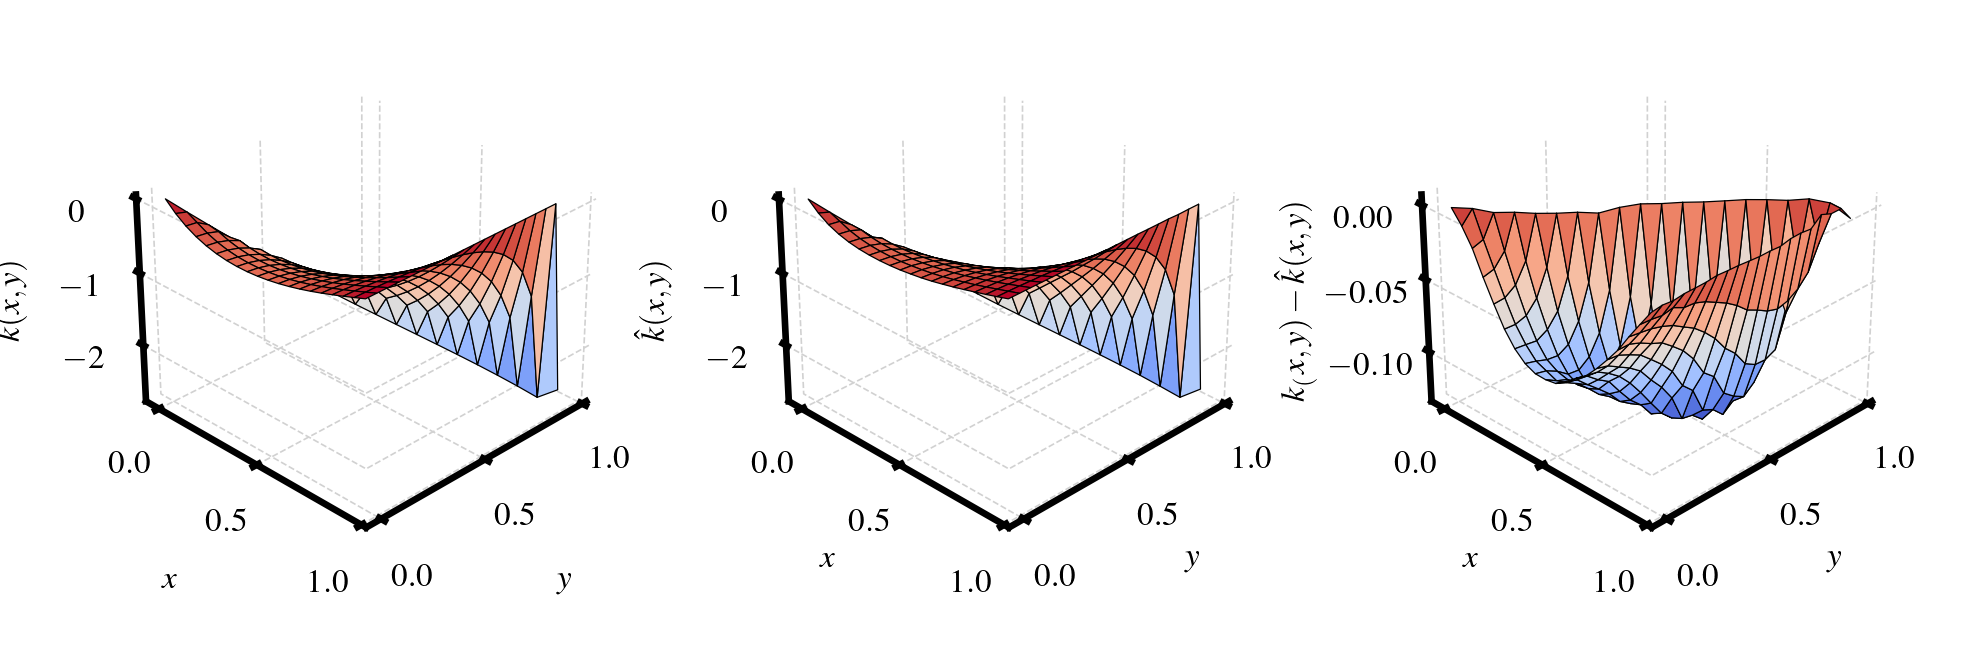

In [58]:
#draw kernel K
k_end =K_all[n, :, :]
Ku = k_end
KuNop = l_1


spatial2 = x

my_dpi = 300
res = 10
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
meshy, meshx = np.meshgrid(spatial2, spatial2)


fig = plt.figure(figsize=(1000 / my_dpi, 350 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.1, bottom=0, right=0.99, top=0.99, wspace=0.3, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d"})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[2].xaxis, ax[2].yaxis, ax[2].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
#zeroToNan
#ax[0].plot_surface(meshx, meshy,zeroToNan(Ku),edgecolor="black",lw=0.1, 
                        #color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)  

surf0 = ax[0].plot_surface(
    meshx, meshy,zeroToNan(Ku),
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=1, cstride=1,
    antialiased=True, shade=True, rasterized=True
)

# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(30,-45)
ax[0].set_xlabel(r"$x$",fontsize = 4 , labelpad=-10)
ax[0].set_ylabel(r"$y$",fontsize = 4 , labelpad=-10)
ax[0].set_zlabel(r"${k}(x,y)$", fontsize = 4 , rotation = 90, labelpad=-12)

ax[0].set_xticks([0, 0.5, 1])
ax[0].set_yticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4 , pad=-4)  # x轴标签旋转、字号等 
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
#ax[1].plot_surface(meshx, meshy, zeroToNan(KuNop),edgecolor="black",lw=0.1, 
                        #color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

surf1 = ax[1].plot_surface(
    meshx, meshy,zeroToNan(KuNop),
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=1, cstride=1,
    antialiased=True, shade=True, rasterized=True
)


# vals = (u[0:nt:draw_rate,0].transpose()) 
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(30, -45)
ax[1].set_xlabel(r"$x$",fontsize = 4 , labelpad=-12)
ax[1].set_ylabel(r"$y$",fontsize = 4 , labelpad=-12)
ax[1].set_zlabel(r"$\hat{k}(x,y)$", fontsize = 4 ,rotation = 90, labelpad=-12)
#x[1].set_zlabel(r"$\hat L(s+hr)$", fontsize = 4 ,rotation = 90, labelpad=-14)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_yticks([0, 0.5, 1])
# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 


#ax[2].plot_surface(meshx, meshy, zeroToNan(Ku-KuNop),edgecolor="black",lw=0.1, 
                        #color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
surf2 = ax[2].plot_surface(
    meshx, meshy,zeroToNan(Ku-KuNop),
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=1, cstride=1,
    antialiased=True, shade=True, rasterized=True
)


test = np.zeros(int(301))
# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[2].view_init(30,-45)
ax[2].set_xlabel(r"$x$",fontsize = 4 , labelpad=-12)
ax[2].set_ylabel(r"$y$",fontsize = 4 , labelpad=-12)
ax[2].set_zlabel(r"${k}_(x,y)-\hat{k}(x,y)$",fontsize = 4 , rotation = 90, labelpad=-12)
ax[2].set_xticks([0, 0.5, 1])
ax[2].set_yticks([0, 0.5, 1])
# ax[1].set_zticks([-0.1, 0, 0.1])
ax[2].zaxis.set_rotate_label(False)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 

tmp_planes = ax[1].zaxis._PLANES 
ax[1].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 

tmp_planes = ax[2].zaxis._PLANES 
ax[2].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 
plt.savefig("img/k-IMEX-M-1_2.pdf", bbox_inches="tight")


In [59]:
#===================
# 2-- 中间时刻 M/2
#=====================

n=round(M/2)  #时刻
t = tt[n]
lam_x_all_1 = np.zeros(Nx)
lam_x_all_1 = solveBetaFunctionVar(x, t, sigma_value)
#lam_y_all[:, n] = solveBetaFunctionVar(y, t, sigma_value)
#k = imex_step(k, time_now, dt, x, y, h, N, eps, c, q, lam_vec_sigma_y, USE_LAMBDA_OF_Y_IN_PDE)
#k = imex_step(k, time_now, dt, x, y, h, N, eps, c, q, lam_vec_sigma_y, USE_LAMBDA_OF_Y_IN_PDE)
#k = imex_step(k, n, dt, x, y, h, Nx, eps, c, q, lam_x_all, lam_y_all, USE_LAMBDA_OF_Y_IN_PDE)
lam_matrix = buildc(Nx,lam_x_all_1)
c_matrix = lam_matrix
xdata = np.concatenate([c_matrix.reshape(1,-1)],axis=1)
xdata = np.array(xdata, dtype=np.float32)
xdata = torch.from_numpy(xdata.reshape((1, 1*Nx*Nx))).cuda() # gamma改2
xdata1=xdata[:,0*Nx*Nx:1*Nx*Nx] # [:,0*Nx*Nx:2*Nx*Nx] 前两个 0,1
#print(xdata1)
#print(x.shape[0]) 21
l_1= modelk1((xdata1, grid))
l_1 = l_1.detach().cpu().numpy().reshape(1, Nx*Nx)
l_1=l_1.reshape(Nx,Nx)
#print(l_1)

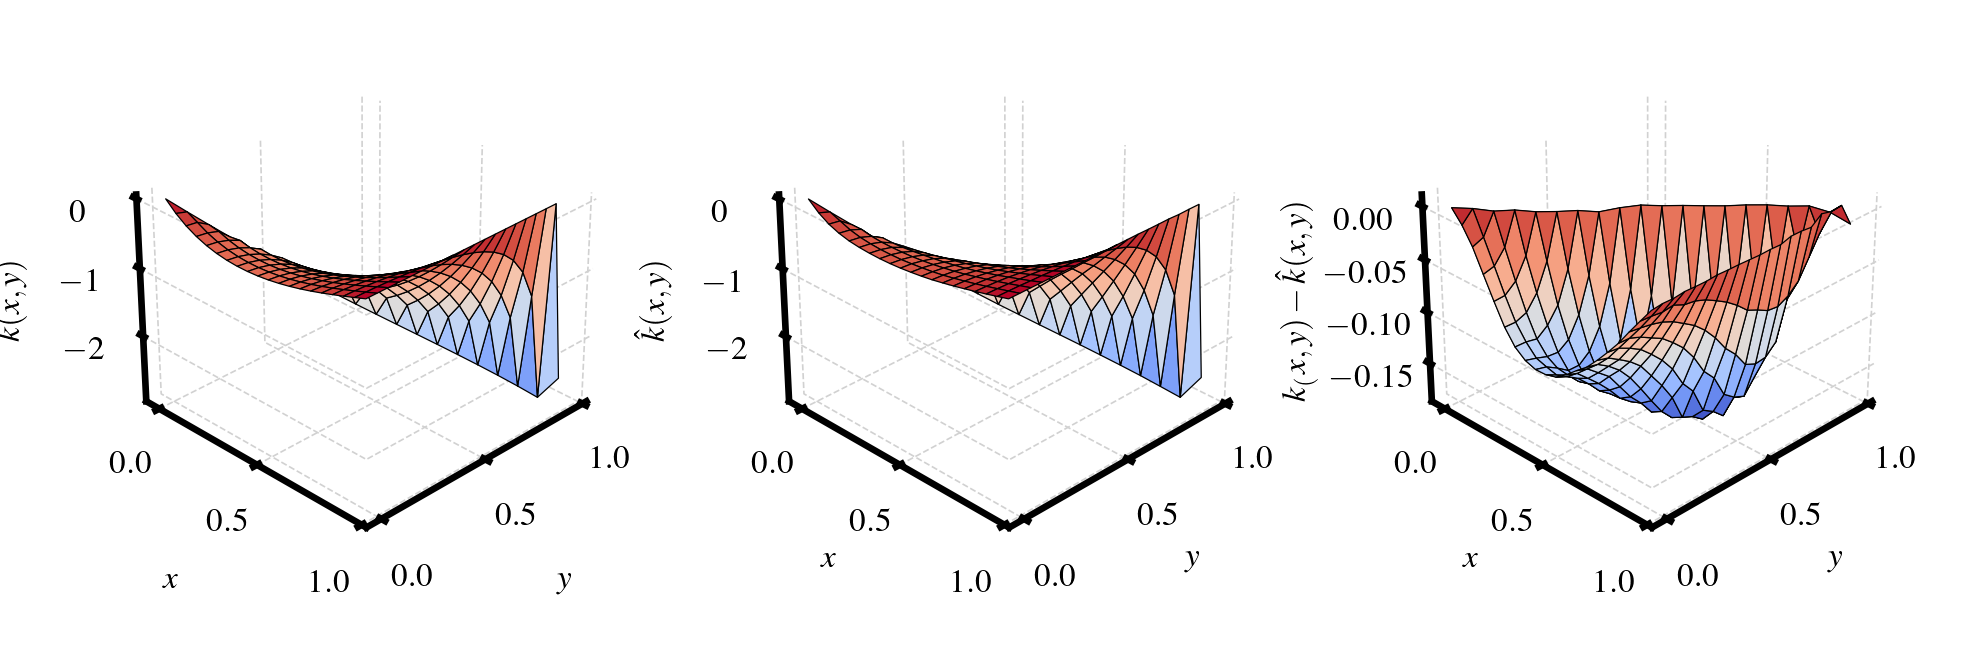

In [60]:
#draw kernel K
k_end =K_all[n, :, :]
Ku = k_end
KuNop = l_1

spatial2 = x

my_dpi = 300
res = 10
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
meshy, meshx = np.meshgrid(spatial2, spatial2)


fig = plt.figure(figsize=(1000 / my_dpi, 350 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.1, bottom=0, right=0.99, top=0.99, wspace=0.3, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d"})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[2].xaxis, ax[2].yaxis, ax[2].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
#zeroToNan
#ax[0].plot_surface(meshx, meshy,zeroToNan(Ku),edgecolor="black",lw=0.1, 
                        #color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1) 
surf0 = ax[0].plot_surface(
    meshx, meshy,zeroToNan(Ku),
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=1, cstride=1,
    antialiased=True, shade=True, rasterized=True
)


# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(30,-45)
ax[0].set_xlabel(r"$x$",fontsize = 4 , labelpad=-10)
ax[0].set_ylabel(r"$y$",fontsize = 4 , labelpad=-10)
ax[0].set_zlabel(r"${k}(x,y)$", fontsize = 4 , rotation = 90, labelpad=-12)

ax[0].set_xticks([0, 0.5, 1])
ax[0].set_yticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4 , pad=-4)  # x轴标签旋转、字号等 
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
#ax[1].plot_surface(meshx, meshy, zeroToNan(KuNop),edgecolor="black",lw=0.1, 
                        #color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
surf1 = ax[1].plot_surface(
    meshx, meshy,zeroToNan(KuNop),
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=1, cstride=1,
    antialiased=True, shade=True, rasterized=True
)

# vals = (u[0:nt:draw_rate,0].transpose()) 
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(30, -45)
ax[1].set_xlabel(r"$x$",fontsize = 4 , labelpad=-12)
ax[1].set_ylabel(r"$y$",fontsize = 4 , labelpad=-12)
ax[1].set_zlabel(r"$\hat{k}(x,y)$", fontsize = 4 ,rotation = 90, labelpad=-12)
#x[1].set_zlabel(r"$\hat L(s+hr)$", fontsize = 4 ,rotation = 90, labelpad=-14)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_yticks([0, 0.5, 1])
# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 


ax[2].plot_surface(meshx, meshy, zeroToNan(Ku-KuNop),edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
surf2 = ax[2].plot_surface(
    meshx, meshy,zeroToNan(Ku-KuNop),
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=1, cstride=1,
    antialiased=True, shade=True, rasterized=True
)

test = np.zeros(int(301))
# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[2].view_init(30,-45)
ax[2].set_xlabel(r"$x$",fontsize = 4 , labelpad=-12)
ax[2].set_ylabel(r"$y$",fontsize = 4 , labelpad=-12)
ax[2].set_zlabel(r"${k}_(x,y)-\hat{k}(x,y)$",fontsize = 4 , rotation = 90, labelpad=-12)
ax[2].set_xticks([0, 0.5, 1])
ax[2].set_yticks([0, 0.5, 1])
# ax[1].set_zticks([-0.1, 0, 0.1])
ax[2].zaxis.set_rotate_label(False)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 

tmp_planes = ax[1].zaxis._PLANES 
ax[1].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 

tmp_planes = ax[2].zaxis._PLANES 
ax[2].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 
plt.savefig("img/k-IMEX-M2_2.pdf", bbox_inches="tight")


In [61]:
#===================
# 3-- 五分之一时刻 M/5
#=====================

n=round(M/5)  #时刻
t = tt[n]
lam_x_all_1 = np.zeros(Nx)
lam_x_all_1 = solveBetaFunctionVar(x, t, sigma_value)
#lam_y_all[:, n] = solveBetaFunctionVar(y, t, sigma_value)
#k = imex_step(k, time_now, dt, x, y, h, N, eps, c, q, lam_vec_sigma_y, USE_LAMBDA_OF_Y_IN_PDE)
#k = imex_step(k, time_now, dt, x, y, h, N, eps, c, q, lam_vec_sigma_y, USE_LAMBDA_OF_Y_IN_PDE)
#k = imex_step(k, n, dt, x, y, h, Nx, eps, c, q, lam_x_all, lam_y_all, USE_LAMBDA_OF_Y_IN_PDE)
lam_matrix = buildc(Nx,lam_x_all_1)
c_matrix = lam_matrix
xdata = np.concatenate([c_matrix.reshape(1,-1)],axis=1)
xdata = np.array(xdata, dtype=np.float32)
xdata = torch.from_numpy(xdata.reshape((1, 1*Nx*Nx))).cuda() # gamma改2
xdata1=xdata[:,0*Nx*Nx:1*Nx*Nx] # [:,0*Nx*Nx:2*Nx*Nx] 前两个 0,1
#print(xdata1)
#print(x.shape[0]) 21
l_1= modelk1((xdata1, grid))
l_1 = l_1.detach().cpu().numpy().reshape(1, Nx*Nx)
l_1=l_1.reshape(Nx,Nx)
#print(l_1)

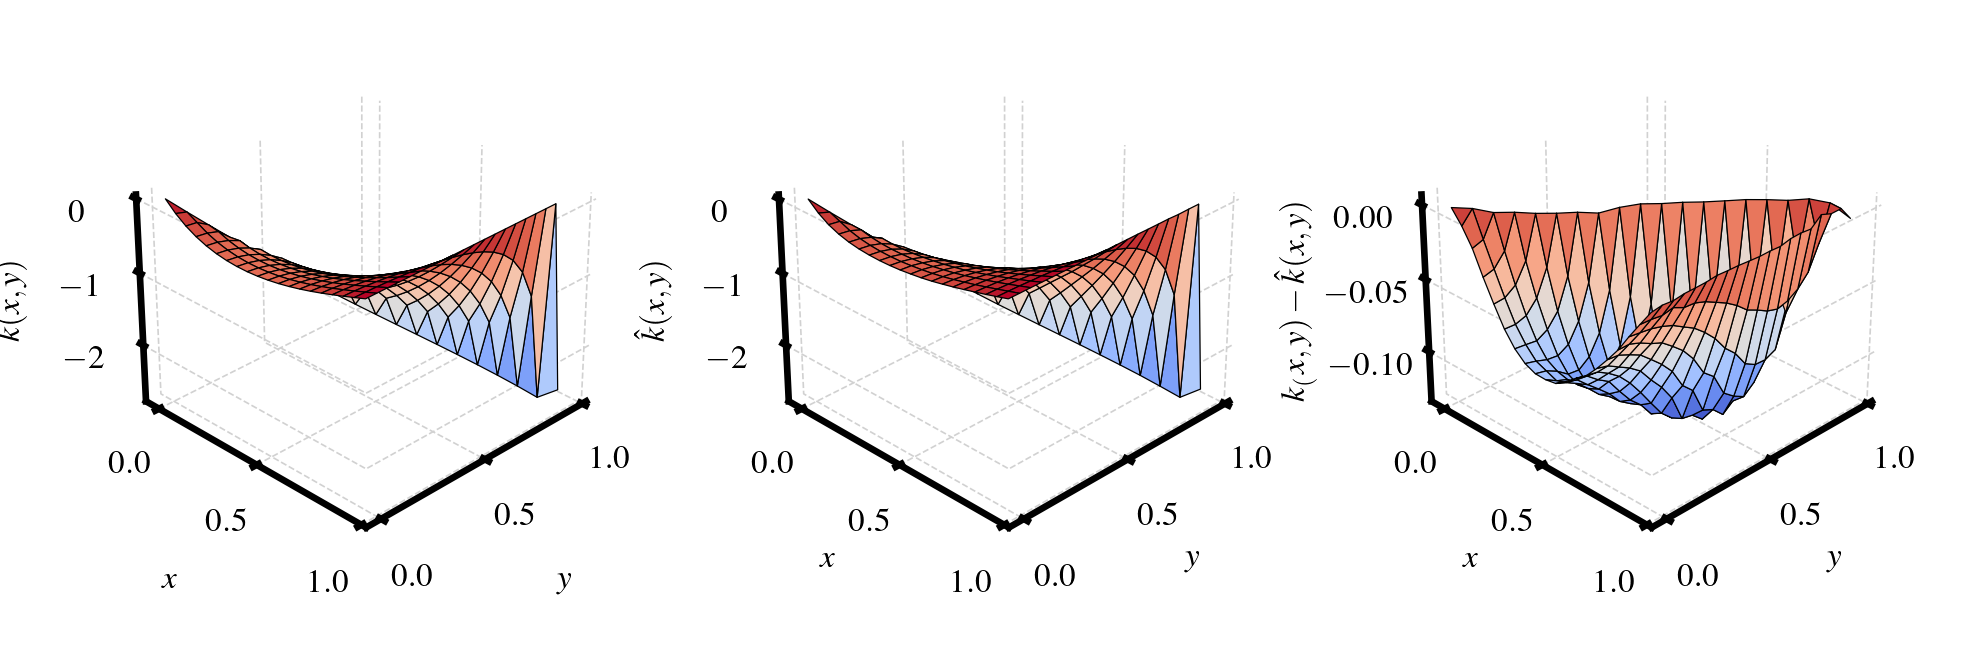

In [62]:
#draw kernel K
k_end =K_all[n, :, :]
Ku = k_end
KuNop = l_1


spatial2 = x

my_dpi = 300
res = 10
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
meshy, meshx = np.meshgrid(spatial2, spatial2)


fig = plt.figure(figsize=(1000 / my_dpi, 350 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.1, bottom=0, right=0.99, top=0.99, wspace=0.3, hspace=0)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d"})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[2].xaxis, ax[2].yaxis, ax[2].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
#zeroToNan
#ax[0].plot_surface(meshx, meshy,zeroToNan(Ku),edgecolor="black",lw=0.1, 
                        #color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
surf0 = ax[0].plot_surface(
    meshx, meshy,zeroToNan(Ku),
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=1, cstride=1,
    antialiased=True, shade=True, rasterized=True
)


# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(30,-45)
ax[0].set_xlabel(r"$x$",fontsize = 4 , labelpad=-10)
ax[0].set_ylabel(r"$y$",fontsize = 4 , labelpad=-10)
ax[0].set_zlabel(r"${k}(x,y)$", fontsize = 4 , rotation = 90, labelpad=-12)

ax[0].set_xticks([0, 0.5, 1])
ax[0].set_yticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4 , pad=-4)  # x轴标签旋转、字号等 
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
#ax[1].plot_surface(meshx, meshy, zeroToNan(KuNop),edgecolor="black",lw=0.1, 
                        #color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
surf1 = ax[1].plot_surface(
    meshx, meshy,zeroToNan(KuNop),
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=1, cstride=1,
    antialiased=True, shade=True, rasterized=True
)

# vals = (u[0:nt:draw_rate,0].transpose()) 
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(30, -45)
ax[1].set_xlabel(r"$x$",fontsize = 4 , labelpad=-12)
ax[1].set_ylabel(r"$y$",fontsize = 4 , labelpad=-12)
ax[1].set_zlabel(r"$\hat{k}(x,y)$", fontsize = 4 ,rotation = 90, labelpad=-12)
#x[1].set_zlabel(r"$\hat L(s+hr)$", fontsize = 4 ,rotation = 90, labelpad=-14)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_yticks([0, 0.5, 1])
# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 


#ax[2].plot_surface(meshx, meshy, zeroToNan(Ku-KuNop),edgecolor="black",lw=0.1, 
                        #color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
surf2 = ax[2].plot_surface(
    meshx, meshy,zeroToNan(Ku-KuNop),
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=1, cstride=1,
    antialiased=True, shade=True, rasterized=True
)
test = np.zeros(int(301))
# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[2].view_init(30,-45)
ax[2].set_xlabel(r"$x$",fontsize = 4 , labelpad=-12)
ax[2].set_ylabel(r"$y$",fontsize = 4 , labelpad=-12)
ax[2].set_zlabel(r"${k}_(x,y)-\hat{k}(x,y)$",fontsize = 4 , rotation = 90, labelpad=-12)
ax[2].set_xticks([0, 0.5, 1])
ax[2].set_yticks([0, 0.5, 1])
# ax[1].set_zticks([-0.1, 0, 0.1])
ax[2].zaxis.set_rotate_label(False)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=4, pad=-4 )  # x轴标签旋转、字号等 

tmp_planes = ax[1].zaxis._PLANES 
ax[1].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 

tmp_planes = ax[2].zaxis._PLANES 
ax[2].zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5]) 
plt.savefig("img/k-IMEX-M5_2.pdf", bbox_inches="tight")


print(U, U_NO)
u =u_record.T
uNop = u_record_NO.T
v=u
vNop=uNop
spatial=x
temporal=tt

u =u_record.T
uNop = u_record_NO.T

spatial=x
temporal=tt
nt=Nt

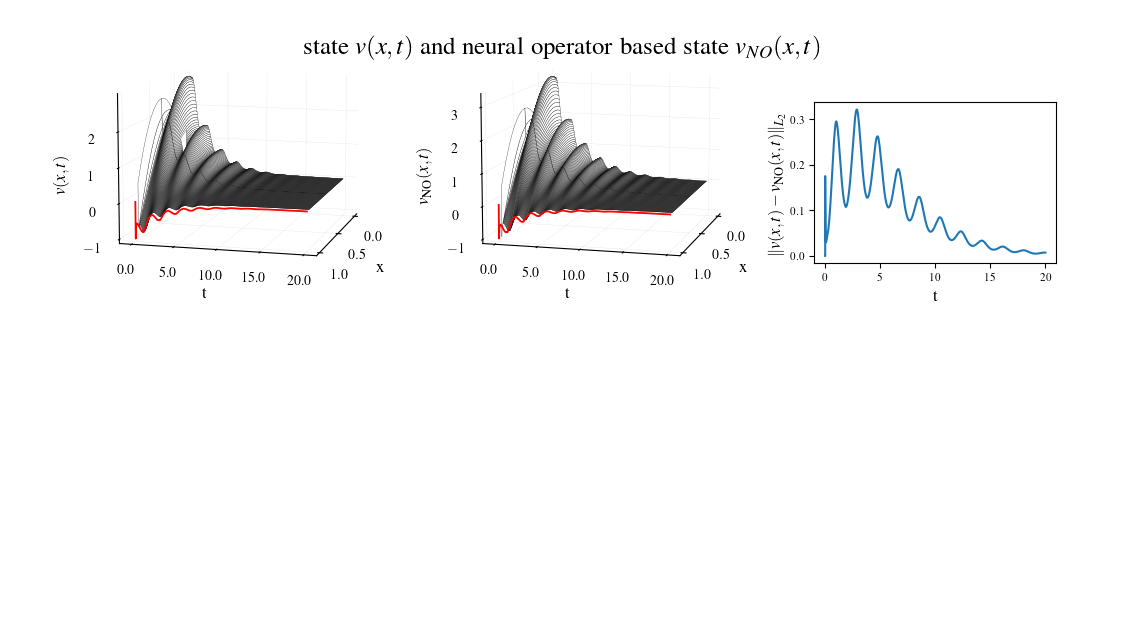

In [23]:
# 1行两列：画状态u uNop, 
# 先画 u uNop
u =u_record.T
uNop = u_record_NO.T
spatial=x
temporal=tt
nt=Nt

res = 1
fig = plt.figure(figsize=set_size(1000, 0.8, (2,3), height_add=1.3)) #(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)


#第一行
#（1，1）位置的图
subfig = subfigs[0]
#subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
#subfig.suptitle(r"Adaptive Neural Operator Control $u(x, t)$ for $\sigma=2.9, 3.1$")
subfig.suptitle(r"state $v(x, t)$ and neural operator based state ${v}_{NO}(x, t)$", fontsize=18)
axes = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d", "computed_zorder": False})



for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1,1,1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes[0].plot_surface(meshx, mesht, u, edgecolor="black",lw=0.2, rstride=70, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uNop.transpose())[-1] 
axes[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[0].view_init(10, 15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$v(x, t)$", rotation=90)
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#（1，2）位置的图
axes[1].plot_surface(meshx, mesht, uNop, edgecolor="black",lw=0.2, rstride=70, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uNop.transpose())[-1] 
axes[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[1].view_init(10, 15)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$v_{\rm NO}(x,t)$", rotation=90)
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

#（1，3）位置的图
axes[2].remove()  # 移除第三个 3D 子图，为 2D 图留出空间
ax2d = subfig.add_subplot(1, 3, 3)  # 添加 2D 图到第三个位置

ee_state=u-uNop
error_u_state_L2=np.sqrt(np.sum(ee_state*ee_state,axis=1)*dx)
nt_draw=nt #2000

#fig=plt.figure(figsize=(800 / my_dpi, 500 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
#plt.plot(temporal[0:nt_draw], error_u_state_L2[0:nt_draw],linewidth=1.5)
#plt.xlabel(r'$\rm{Time}$',fontsize="8")
#plt.ylabel(r'$\Vert u(x,t) -  u_{\rm NO}(x,t)\Vert_{L_2}$',fontsize="8")
#plt.tick_params(labelsize=8)

#fig = plt.gcf()
#fig.tight_layout()
# plt.savefig('img/L2error_state.eps', dpi=300,bbox_inches='tight')


# 绘制第三个 2D 图
pos3 = ax2d.get_position()  # 获取当前的position
new_pos3 = [pos3.x0, pos3.y0 + 0.2, pos3.width * 0.8, pos3.height * 0.5]  # 缩小尺寸
ax2d.set_position(new_pos3)  # 设置新的position


ax2d.plot(temporal[0:nt_draw], error_u_state_L2[0:nt_draw],linewidth=1.5)
ax2d.set_xlabel(r'$\rm{t}$',fontsize="12")
ax2d.set_ylabel(r'$\Vert v(x,t) -  v_{\rm NO}(x,t)\Vert_{L_2}$',fontsize="12")
plt.tick_params(labelsize=8)
# ax2d.set_title("2D Plot")

# 显示图形
# plt.show() 
plt.savefig("img/u_uNO-1.png", dpi=600)

In [ ]:
cmap = plt.get_cmap("viridis") 

In [63]:

#开环
u_record_open, U_open, K_all_open = solve_state_implicit_euler(
    x, y, tt, imex_step, eps, c, q, lam_x_all, lam_y_all, 
    u0_func, initial_k, USE_LAMBDA_OF_Y_IN_PDE,solveControl_Openloop)

核函数k和状态u求解完成！


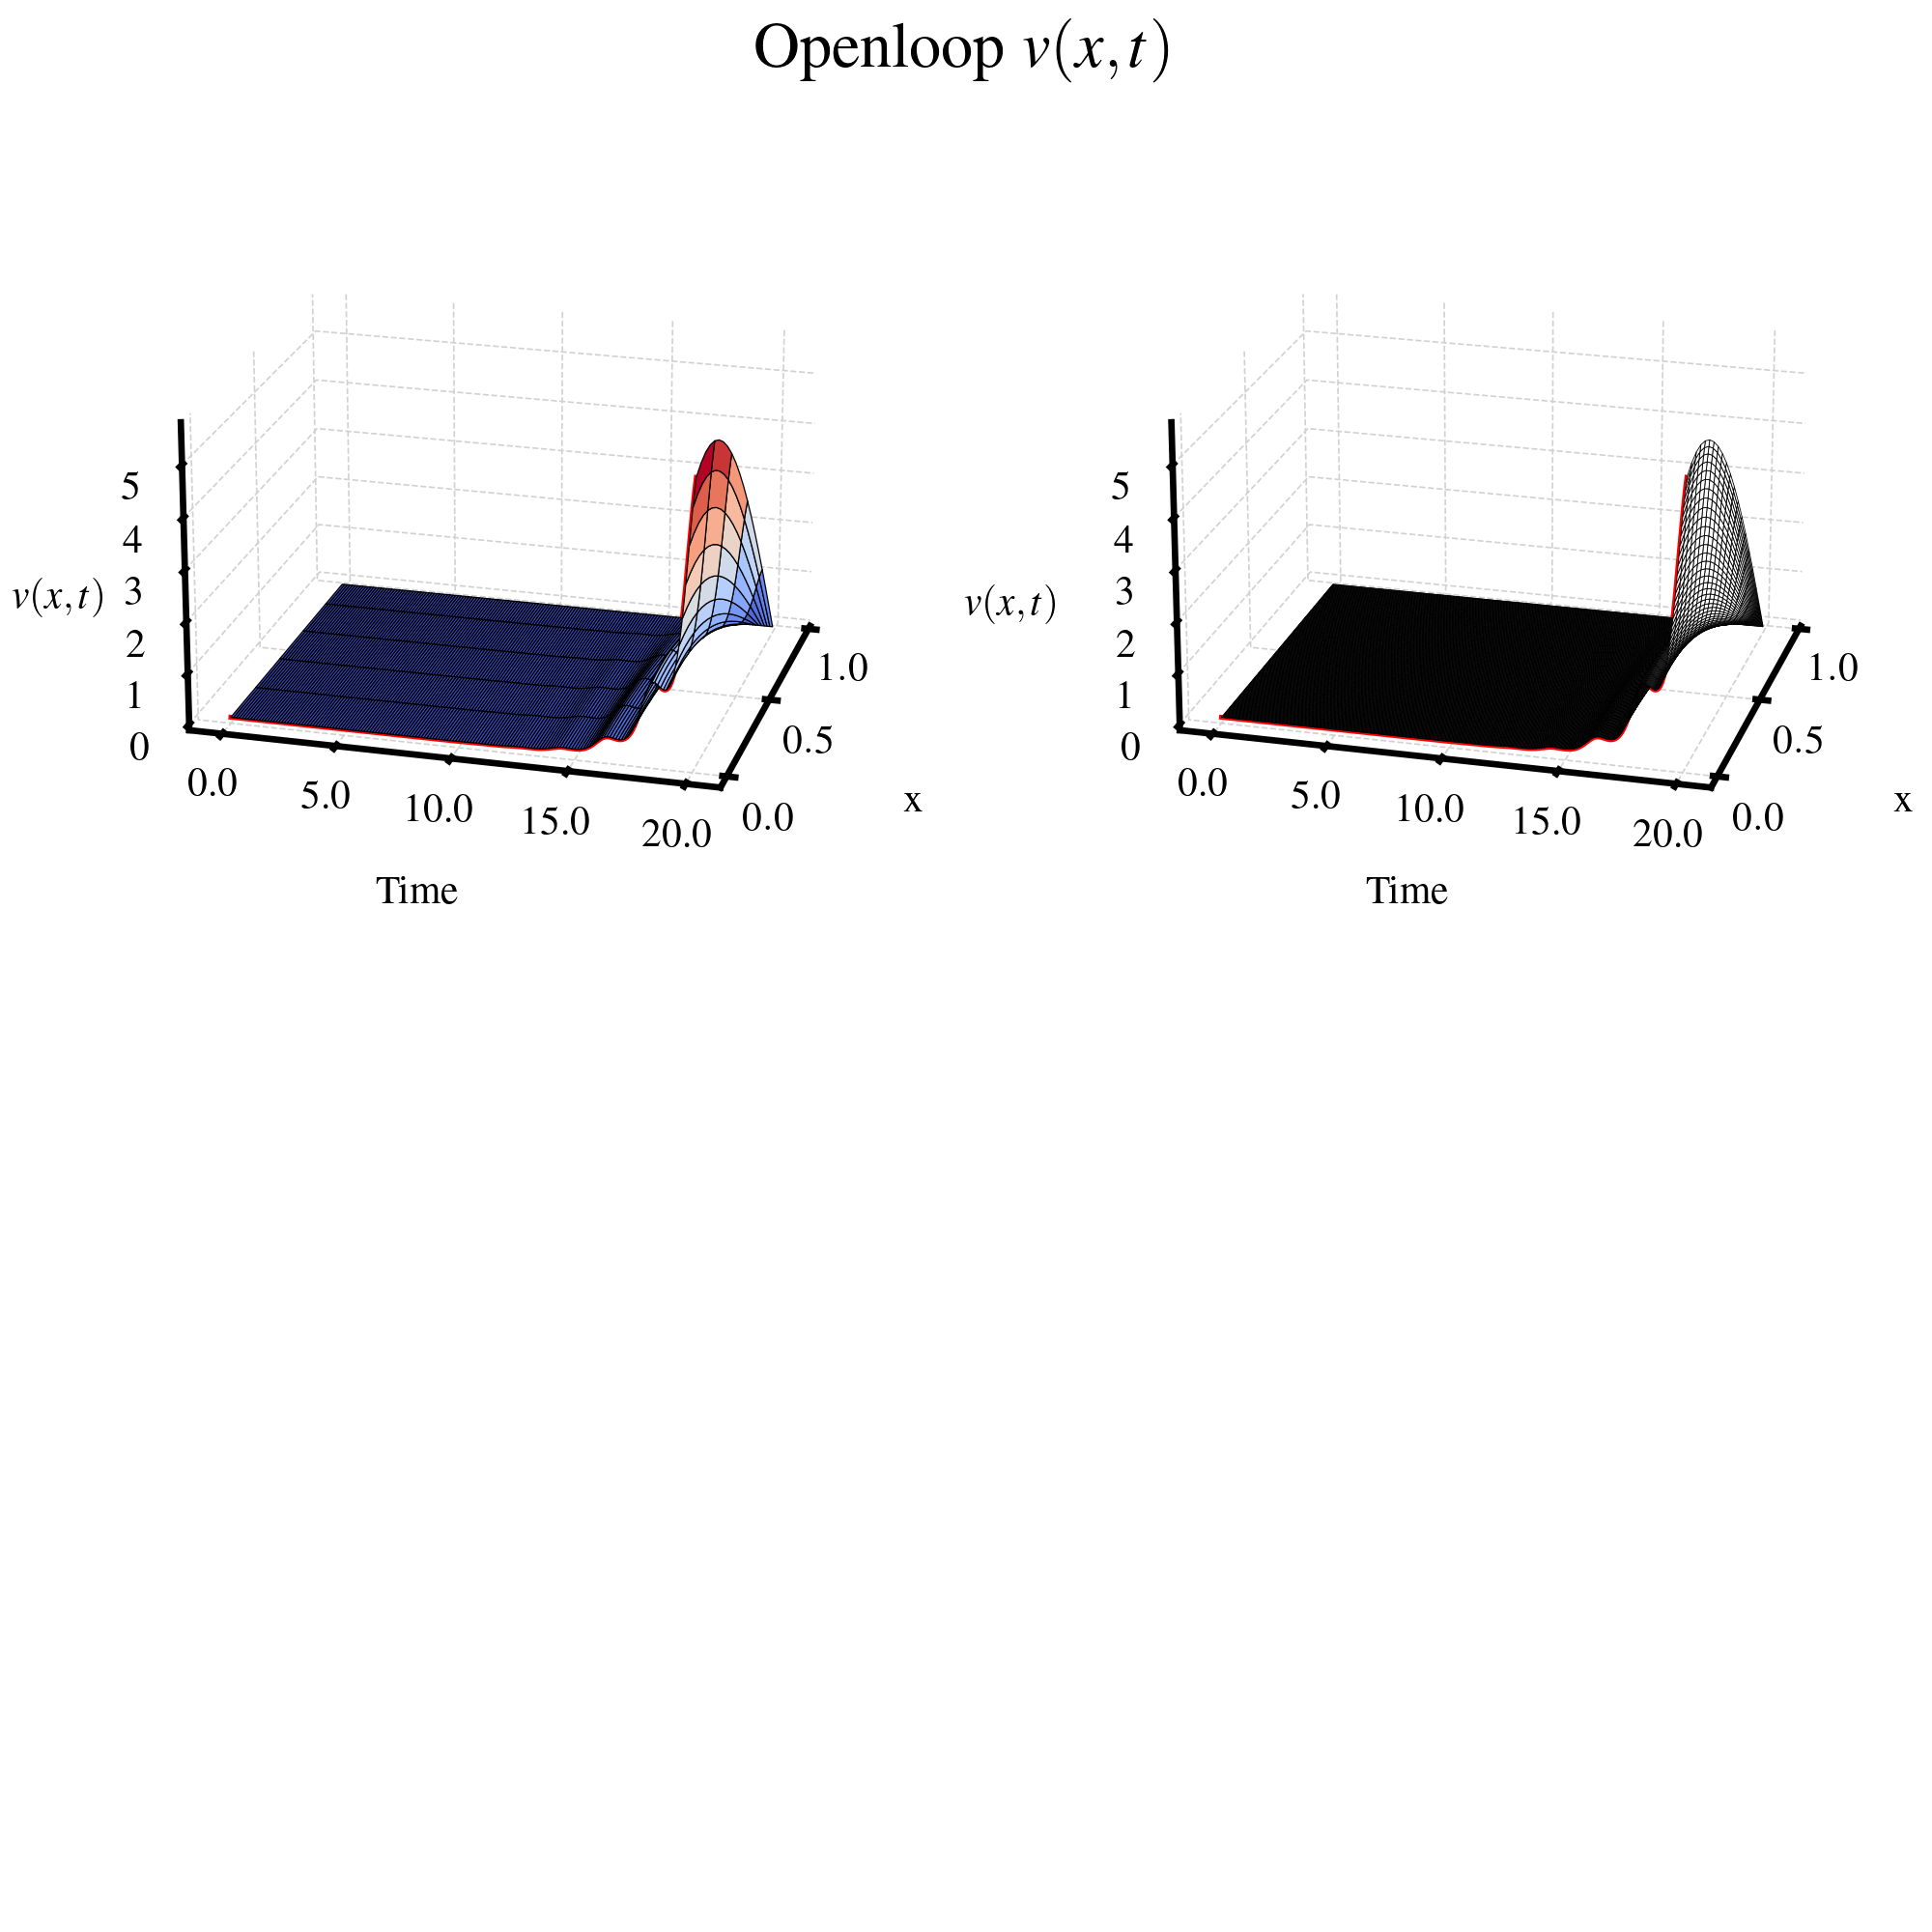

In [67]:
#画开环的状态

#u = u_record.T
#uhat = u_record_NO.T
ww=u_record_open.T
wwlearning=u_record_open.T
my_dpi=300
# res = 10
draw_rate = 50
nt=Nt
nt_draw=nt
nx=Nx
#ax = plt.gca()
temporal_draw=temporal[0:nt_draw:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw)
test=np.zeros(len(temporal_draw))
# fig = plt.figure(figsize=set_size(2000, 0.99, (2, 2), height_add=1))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 1000 / my_dpi), dpi=600)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
#ax[0]=Axes3D(fig)
#ax[1]=Axes3D(fig)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.05, bottom=0, right=0.99, top=0.99, wspace=0.2, hspace=0)
subfig.suptitle(r"Openloop $v(x, t)$", fontsize=8)

# subfig.suptitle(r"Closed-loop $u_{NO}(x, t)$ for $\gamma$ = 5, 8")
# meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d"})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))

    
# ax[0].plot_surface(meshx, meshy, zeroToNan(kappa1)-zeroToNan(k1),edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)   
#ax[0].plot_surface(meshx2, mesht2, ww[0:nt_draw:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        #color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
surf0 = ax[0].plot_surface(
    meshx2, mesht2, ww[0:nt_draw:draw_rate,0:nx],
    cmap=cmap, #norm=norm,
    edgecolor="k", lw=0.15,
    rstride=4, cstride=4,
    antialiased=True, shade=True, rasterized=True
)



# ax.plot_surface(meshx2, mesht2, ulearning_est[0:nt:draw_rate,:],  
#                         cmap = cm.coolwarm, shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[0].plot(test, temporal_draw, ww[0:nt_draw:draw_rate,0], color="red", lw=0.6, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例

# vals = (u[0:nt:draw_rate,0].transpose())
zticks = np.linspace(-15, 12, 6)
# ax[0].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(20,15)
ax[0].set_xlabel("x",fontsize = 5 , labelpad=-6)
ax[0].set_ylabel("Time",fontsize = 5 , labelpad=-6)
ax[0].set_zlabel("$v(x,t)$",fontsize = 5 ,  labelpad=-11)  #rotation = 90, 旋转
ax[0].set_xticks([0, 0.5, 1])
# ax[0].set_yticks([0, 10, 20, 30, 40, 50])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5 , pad=-4)  # x轴标签旋转、字号等 

ax[1].plot_surface(meshx2, mesht2, wwlearning[0:nt_draw:draw_rate,0:nx], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
# ax[1].plot_surface(meshx, meshy, kappa2-k2,edgecolor="black",lw=0.1, 
#                         color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)
ax[1].plot(test, temporal_draw, wwlearning[0:nt_draw:draw_rate,0], color="red", lw=0.6, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))#前3个参数用来调整各坐标轴的缩放比例
# vals = (u[0:nt:draw_rate,0].transpose())
# ax[1].plot(test, temporal_draw, vals, color="red", lw=1.3, antialiased=True)
ax[1].view_init(20, 15)
ax[1].set_xlabel("x",fontsize = 5 , labelpad=-6)
ax[1].set_ylabel("Time",fontsize = 5 , labelpad=-6)
ax[1].set_zlabel(r"$v(x,t)$", fontsize = 5 , labelpad=-8)#r"$w_{\rm NO}(x,t)$"     rotation = 90,
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
# ax[1].set_yticks([0, 25, 50])
# ax[1].set_yticks(np.arange(0,60,10))

# ax[1].set_zticks([-2, 0, 2])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES
ax[1].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5]) 
ax[1].tick_params(axis='both',  # 可选'y'，'both'
                      labelsize=5, pad=-4 )  # x轴标签旋转、字号等 
plt.savefig("img/u_open.pdf", bbox_inches="tight")


In [ ]:
# Computation time comparison
# Parameter Definition

# NO's computatinal time
timeSum2 = 0
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
        s = time.time() 
        out = modelk1((x, grid))
        timeSum2 += time.time()-s
time2 = timeSum2/(ndata*0.1)
print(time2)

# Tranditinal method's computatinal time
timeSum = 0
for i in range(100):
    s = time.time()
    #K1, K2, K3, N, gamma= kernel_estimator(Sigma11, Sigma12, Sigma21.T, Sigma22, Q, A, B, C, C_0, dx, Nx, Lambda, 1)
    timeSum += time.time()-s
time1 = timeSum/100
print(time1)

print(time1/time2)